# Plot Figure 11

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import netCDF4 as nc
import os
from pathlib import Path

# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [2]:
file_path = Path("data/")
files = list(file_path.glob("*fig11*"))

In [3]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries

In [4]:
data = files[3]
data_in = xr.open_dataset(data, engine="netcdf4", decode_times=False).metpy.quantify()
data_in["time"] = cftime.num2date(data_in.time, "hours since 1850-01-01 03:00:00", calendar="noleap", has_year_zero=True)

In [5]:
# convert to mm/day and assign units to precip rate (units unspecified in raw data, but CMIP6 specs say its reported in kg/m2/s)
# https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271
data_in["pr"] = data_in.pr * 86400 * units('mm/day')
#data_in["pr"] = data_in.pr * units('mm/day')

# get dew point temp
try:
    data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)
except ValueError:
    data_in["tas"] = data_in.tas * units.kelvin
    data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

# calculate the evaporative fraction (Betts eq 9)
data_in["EF"] = abs(data_in.hfls) / (abs(data_in.hfls) + abs(data_in.hfss))

/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


In [6]:
# compute the spatial average
spatial_average = data_in.mean(dim=("lat", "lon")).dropna(dim="time")

ValueError: conflicting sizes for dimension 'time': length 154 on 'plcl' and length 482113 on {'time': 'time'}

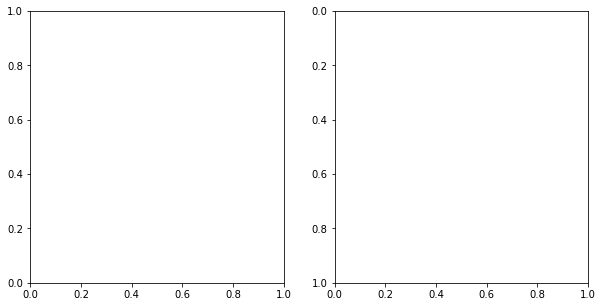

In [9]:
# figure to match Betts exactly
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.gca().invert_yaxis()

# calculate plcl and add to the dataset
plcl, tlcl = mpcalc.lcl(ps, spatial_average.tas, spatial_average.td)
lcl_dep = ps - plcl

spatial_average["plcl"] = ["time"], plcl_hpa
 
light_pr = spatial_average.pr <= 1 * units('mm/day')
med1_pr = (1 * units('mm/day') <= spatial_average.pr) | (spatial_average.pr < 3 * units('mm/day'))
med2_pr = (3 * units('mm/day') <= spatial_average.pr) | (spatial_average.pr < 5 * units('mm/day'))
heavy_pr = (5 * units('mm/day') <= spatial_average.pr)

ax1.scatter(spatial_average.mrsos[light_pr], lcl_dep - spatial_average.plcl[light_pr], label="PR < 1 mm day$^{-1}$", alpha=alpha)
ax1.scatter(spatial_average.mrsos[med1_pr], lcl_dep - spatial_average.plcl[med1_pr], label="1 < PR < 3 mm day$^{-1}$", alpha=alpha)
ax1.scatter(spatial_average.mrsos[med2_pr], lcl_dep - spatial_average.plcl[med2_pr], label="3 < PR < 5 mm day$^{-1}$", alpha=alpha)
ax1.scatter(spatial_average.mrsos[heavy_pr], lcl_dep - spatial_average.plcl[heavy_pr], label="5 < PR mm day$^{-1}$", alpha=alpha)

ax2.scatter(spatial_average.EF[light_pr], lcl_dep - spatial_average.plcl[light_pr], label="PR < 1 mm day$^{-1}$", alpha=alpha)
ax2.scatter(spatial_average.EF[med1_pr], lcl_dep - spatial_average.plcl[med1_pr], label="1 < PR < 3 mm day$^{-1}$", alpha=alpha)
ax2.scatter(spatial_average.EF[med2_pr], lcl_dep - spatial_average.plcl[med2_pr], label="3 < PR < 5 mm day$^{-1}$", alpha=alpha)
ax2.scatter(spatial_average.EF[heavy_pr], lcl_dep - spatial_average.plcl[heavy_pr], label="5 < PR mm day$^{-1}$", alpha=alpha)

ax1.legend(loc='upper right')

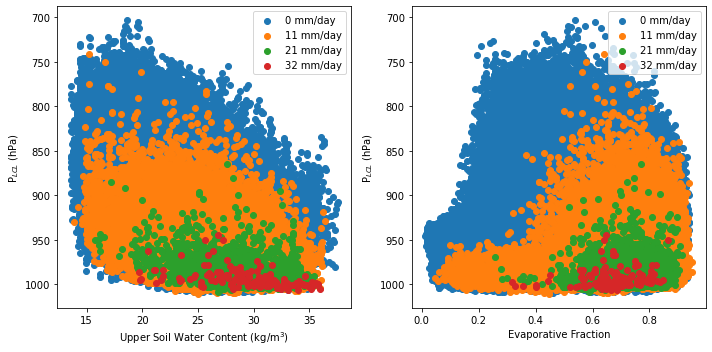

In [8]:
# sort the file into 6 groups based on soil moisture content
the_max = float(spatial_average.pr.max().values)
the_min = float(spatial_average.pr.min().values)
the_range =  the_max - the_min

spatial_average["precip_group"] = ((spatial_average.pr / (the_range / 4)).round() * (the_range / 4)).round()
gbypr = spatial_average.groupby(spatial_average.precip_group)

pr_keys = list(gbypr.groups.keys())
pr_keys.remove(max(pr_keys))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

for key in pr_keys:
    # find and plot the lcl as a function of soil moisture
    plcl, tlcl = mpcalc.lcl(ps, gbypr[key].tas, gbypr[key].td)
    plcl_hpa = plcl / 100
    
    ax1.scatter(gbypr[key].mrsos, plcl_hpa, label=f"{round(key)} mm/day")
    ax2.scatter(gbypr[key].EF, plcl_hpa, label=f"{round(key)} mm/day")

ax1.legend(loc="upper right")
ax1.set_xlabel("Upper Soil Water Content (kg/m$^3$)")
ax1.set_ylabel("P$_{LCL}$ (hPa)")
ax1.invert_yaxis()

ax2.legend(loc="upper right")
ax2.set_xlabel("Evaporative Fraction")
ax2.set_ylabel("P$_{LCL}$ (hPa)")
ax2.invert_yaxis()

plt.tight_layout()